In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch 
import os
import cv2
import torch.nn as nn
import torchvision
from torch.nn import init 
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.datasets as dset
import matplotlib.pyplot as plt
root1 = '/content/drive/MyDrive/Brain_tumor_dataset/'

In [5]:
batch_size= 128
workers =2
image_size = 64
nc = 3
nz =100
ngf = 64
ndf = 64
num_epochs= 500
lr = 0.0002
ngpu =1
beta1 = 0.5

In [6]:
#dataset = dset.MNIST(root='./data', train=True, download=True, transform=None)
dataset = dset.ImageFolder(root =os.path.join(root1),transform=transforms.Compose([
     transforms.Resize(image_size),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
 ]))
dataLoader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=False,num_workers=workers)
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu >0) else 'cpu')

In [7]:
img_data = []
path="/content/drive/MyDrive/Brain_tumor_dataset/tumor/"
for name in os.listdir(path):
  img = cv2.imread(path+"/"+name)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = np.array(cv2.resize(img,(64,64))) 
  img_data.append(img) 
img_data=np.array(img_data)

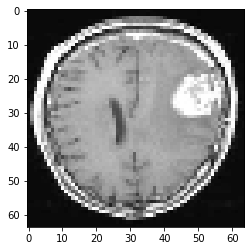

In [8]:
plt.imshow(img_data[0],cmap= 'gray')

In [9]:
def denorm(img_tensors):
    return (img_tensors*0.5+0.5)

In [10]:
# for image in dataLoader:
#   f = plt.figure() 
#   print(image[0].shape)
#   plt.imshow(image[0].squeeze()[0,:,:],cmap='gray') 
#   plt.show() 
#   break

In [11]:
real_batch = next(iter(dataLoader))

torch.Size([128, 3, 64, 64])
<class 'torch.Tensor'>
torch.Size([3, 64, 64])
torch.Size([64])


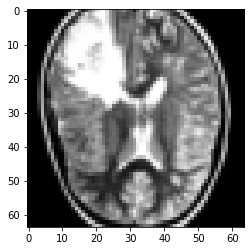

In [12]:
for img_batch,label_batch in dataLoader:
    print(img_batch.shape)
    print(type(img_batch[0]))
    print(img_batch[0].shape)
    print(img_batch[0][2][0].shape)
    # print(label_batch)
    plt.imshow(img_batch[0][0], cmap='gray')
    break

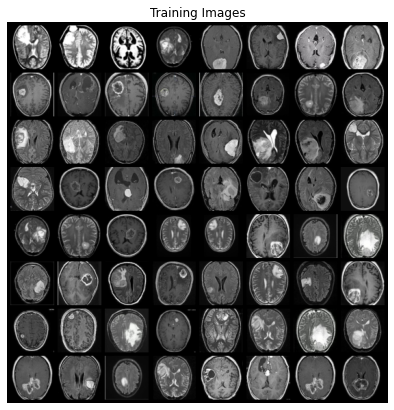

In [13]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Training Images')
#plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(device)[:64],padding= 5,normalize=True).cpu(),(1,2,0)))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5,normalize=True).cpu(),(1,2,0)))

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0)

In [15]:
class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator,self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
        # input z is going into the convolution 
        # nn.ConvTranspose2d(nz,ngf*16,4,4,0,bias=False),
        # nn.BatchNorm2d(ngf*16),
        # nn.ReLU(True), 
        #state_size (128*16,4,4) 
        nn.ConvTranspose2d(nz,ngf*8,4,1,0,bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),
        #state_size = (128*8,8,8)
        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),  
        #state_size= (128*4,16,16)  
        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        # state_size = (128*2,32,32)
        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        #state_size(128,64,64)
        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),    
        nn.Tanh()
        #state_size(3,128,128)
    )     
    def forward(self,input):
        return self.main(input)    

In [16]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu>1):
    netG = nn.DataParallel(netG,list(range(ngpu)))
    
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [17]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator,self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (3,128,128)
            nn.Conv2d(nc,ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace= True),
            #state_size(128,64,64)
            nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            #state_size(128*2,32,32)
            nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            #state_size(128*4,16,16)
            nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            #state_size(128*8,8,8) 
            # nn.Conv2d(ndf*8,ndf*16,4,2,1,bias=False),
            # nn.BatchNorm2d(ndf*16),
            # nn.LeakyReLU(0.2,inplace=True),
            #state_size(128*16,4,4)    
            nn.Conv2d(ndf*8,1,4,1,0,bias=False),    
            nn.Sigmoid()
        )
    def forward(self,input):
        return self.main(input)

In [18]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu>1):
    netD = nn.DataParallel(netD,list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [19]:
import torch.optim as optim
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,nz,1,1,device=device)
real_label =1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(),lr=lr,betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(),lr=lr,betas=(beta1,0.999))

In [20]:
G_losses=[]
D_losses=[]
iters = 0
img_list = []
#import torchmetrics
#from torchmetrics import StructuralSimilarityIndexMeasure
for epoch in range(1,num_epochs+1):
    for i,data in enumerate(dataLoader):
        netD.zero_grad()
        #print(i)
        real_cpu = data[0].to(device)
        #print(data[0].shape)
        #print(len(real_cpu))
        #print(real_cpu)

        b_size = real_cpu.size(0)
        #print(b_size)
        label = torch.full((b_size,),real_label,dtype=torch.float,device=device)
        #print(label.shape)
        output1 = netD(real_cpu).view(-1)
        
        #print(output1.shape)
        #print(label)
        errD_real = criterion(output1,label)
        
        errD_real.backward()
        D_x = output1.mean().item() 
        
        noise = torch.randn(b_size,nz,1,1,device=device)
        #print(noise.shape)
        fake = netG(noise)
        #print(fake.shape)
        label.fill_(fake_label)
        output2 = netD(fake.detach()).view(-1)

        errD_fake = criterion(output2,label)
        errD_fake.backward()
        D_G_z1 = output2.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output3 = netD(fake).view(-1)
        errG = criterion(output3,label)
        errG.backward()
        D_G_z2 = output3.mean().item()
        optimizerG.step()
        
        
        
        if i % 40 == 0:
            print('Epochs[%d/%d]\tIterations[%d/%d]\tLoss_D: %4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                 %(epoch,num_epochs,i,len(dataLoader),errD.item(),errG.item(),D_x,D_G_z1,D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataLoader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=5, normalize=True))
            #ssim = StructuralSimilarityIndexMeasure()
            #ssim(img_list[].reshape(64,64),real_cpu)
        iters += 1

        

Epochs[1/500]	Iterations[0/12]	Loss_D: 2.307826	Loss_G: 4.6052	D(x): 0.4162	D(G(z)): 0.6305 / 0.0152
Epochs[2/500]	Iterations[0/12]	Loss_D: 0.208980	Loss_G: 10.2617	D(x): 0.9721	D(G(z)): 0.1330 / 0.0001
Epochs[3/500]	Iterations[0/12]	Loss_D: 0.165681	Loss_G: 20.4946	D(x): 0.9341	D(G(z)): 0.0000 / 0.0000
Epochs[4/500]	Iterations[0/12]	Loss_D: 0.184453	Loss_G: 14.6850	D(x): 0.8900	D(G(z)): 0.0000 / 0.0000
Epochs[5/500]	Iterations[0/12]	Loss_D: 1.097760	Loss_G: 14.8357	D(x): 0.7837	D(G(z)): 0.4721 / 0.0000
Epochs[6/500]	Iterations[0/12]	Loss_D: 1.533541	Loss_G: 18.1051	D(x): 0.3752	D(G(z)): 0.0000 / 0.0000
Epochs[7/500]	Iterations[0/12]	Loss_D: 0.371833	Loss_G: 10.6918	D(x): 0.7733	D(G(z)): 0.0028 / 0.0001
Epochs[8/500]	Iterations[0/12]	Loss_D: 0.286935	Loss_G: 6.6764	D(x): 0.8947	D(G(z)): 0.1337 / 0.0017
Epochs[9/500]	Iterations[0/12]	Loss_D: 0.302697	Loss_G: 7.1229	D(x): 0.9111	D(G(z)): 0.1663 / 0.0010
Epochs[10/500]	Iterations[0/12]	Loss_D: 0.263502	Loss_G: 10.5919	D(x): 0.8157	D(G(z))

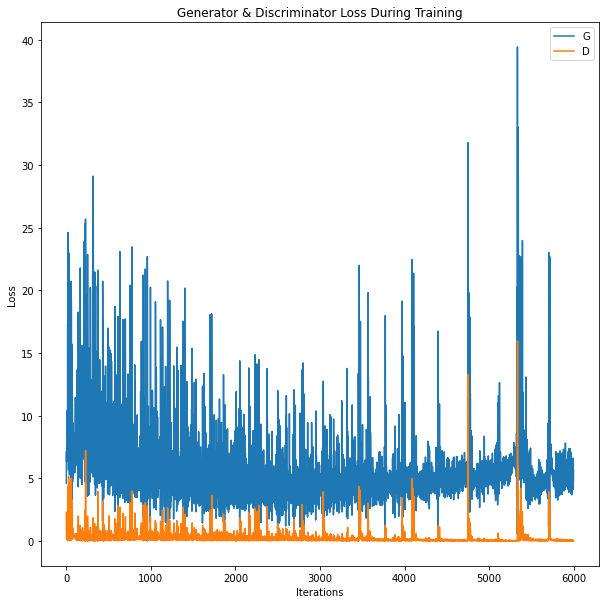

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title("Generator & Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")

plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# from torchvision.utils import save_image
# from torchvision.utils import make_grid
# sample_dir = 'generated'
# os.makedirs(sample_dir, exist_ok=True)

# def save_samples(index, nz, show=True):
#     fake_images = Generator(nz)
#     fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
#     save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname),nrow=5)
#     print('Saving', fake_fname)
#     if show:
#         fig, ax = plt.subplots(figsize=(8, 8))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
# fixed_latent = torch.randn(64, nz, 1, 1, device=device)
# save_samples(0, fixed_latent)        

In [23]:
# from IPython.display import Image
# Image('./generated/generated-images-0001.png')

In [24]:
#pip install torchmetrics

In [25]:
#import torchmetrics
#from torchmetrics import StructuralSimilarityIndexMeasure
#ssim = StructuralSimilarityIndexMeasure()
#a = img_batch[0].shape
#print(a)
#a = real_batch[0].to(device)[:64], padding=5, normalize=True
#b = img_list[0].reshape(64,64)
#print(b)
#ssim(a,b)

ModuleNotFoundError: ignored

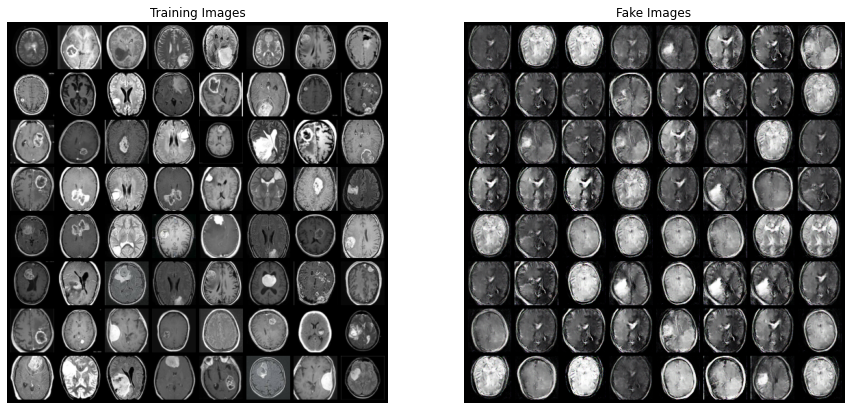

In [ ]:
# Grab a batch of real images from the dataloader

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()